In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Define paths to your data
train_dir = "C:\\Users\\abi\\Downloads\\chest_xray\\train"
test_dir = "C:\\Users\\abi\\Downloads\\chest_xray\\test"
val_dir = "C:\\Users\\abi\\Downloads\\chest_xray\\val"

# Define image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# Balance the data
normal_images = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia_images = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
if normal_images > 0 and pneumonia_images > 0:
    total_samples = normal_images + pneumonia_images
    weight_for_0 = (1 / normal_images) * (total_samples) / 2.0
    weight_for_1 = (1 / pneumonia_images) * (total_samples) / 2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
else:
    raise ValueError("One or more classes have no images in the training data.")


# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model fitting
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    class_weight=class_weight)

# Evaluate model
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test Accuracy:', test_acc)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 267s 2s/step - loss: 0.4347 - accuracy: 0.7922
Epoch 2/10
163/163 [==============================] - 237s 1s/step - loss: 0.2738 - accuracy: 0.8852
Epoch 3/10
163/163 [==============================] - 220s 1s/step - loss: 0.2413 - accuracy: 0.9039
Epoch 4/10
163/163 [==============================] - 338s 2s/step - loss: 0.2201 - accuracy: 0.9078
Epoch 5/10
163/163 [==============================] - 219s 1s/step - loss: 0.2105 - accuracy: 0.9139
Epoch 6/10
163/163 [==============================] - 229s 1s/step - loss: 0.1874 - accuracy: 0.9275
Epoch 7/10
163/163 [==============================] - 227s 1s/step - loss: 0.1971 - accuracy: 0.9241
Epoch 8/10
163/163 [==============================] - 228s 1s/step - loss: 0.1692 - accuracy: 0.9321
Epoch 9/10
163/163 [==============================] - 239s 1s/step - loss: 0.1648 - accuracy: 0.9348
Epoch 10/

In [ ]:
# Calculate the weighted count of normal and pneumonia images
weighted_normal_images = int(normal_images * weight_for_0)
weighted_pneumonia_images = int(pneumonia_images * weight_for_1)

print("Number of balanced normal images:", weighted_normal_images)
print("Number of balanced pneumonia images:", weighted_pneumonia_images)


Number of balanced normal images: 2608
Number of balanced pneumonia images: 2608


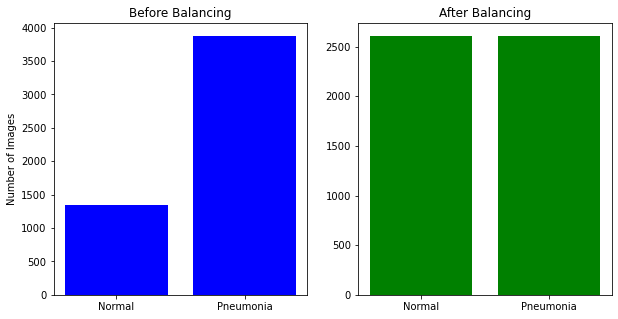

In [ ]:
import os
import matplotlib.pyplot as plt

# Count the number of normal and pneumonia images before balancing
normal_images_before = len(os.listdir(os.path.join(train_dir, 'normal')))
pneumonia_images_before = len(os.listdir(os.path.join(train_dir, 'pneumonia')))

# Calculate the weighted count of normal and pneumonia images after balancing
weighted_normal_images = int(normal_images * weight_for_0)
weighted_pneumonia_images = int(pneumonia_images * weight_for_1)

# Plotting the data distribution
labels = ['Normal', 'Pneumonia']
before_balancing = [normal_images_before, pneumonia_images_before]
after_balancing = [weighted_normal_images, weighted_pneumonia_images]

x = range(len(labels))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(x, before_balancing, color='blue')
plt.title('Before Balancing')
plt.xticks(x, labels)
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
plt.bar(x, after_balancing, color='green')
plt.title('After Balancing')
plt.xticks(x, labels)

plt.show()


Found 624 images belonging to 2 classes.
20/20 [==============================] - 20s 931ms/step


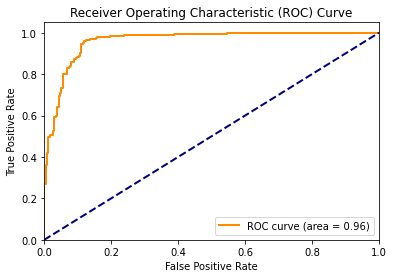

Test Accuracy: 0.9166666666666666
Sensitivity (Recall): 0.9794871794871794
Specificity: 0.811965811965812
Positive Predictive Value (Precision): 0.8967136150234741
Negative Predictive Value: 0.9595959595959596
Prevalence: 0.625
Confusion Matrix:
TN: 190 FP: 44
FN: 8 TP: 382


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, recall_score, precision_score

# Predict labels for test data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=False)

test_pred = model.predict(test_generator)
test_labels = test_generator.classes

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_pred > 0.5)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, test_pred > 0.5).ravel()

# Calculate sensitivity (recall)
sensitivity = recall_score(test_labels, test_pred > 0.5)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate positive predictive value (precision)
ppv = precision_score(test_labels, test_pred > 0.5)

# Calculate negative predictive value
npv = tn / (tn + fn)

# Calculate prevalence
prevalence = (tp + fn) / (tp + tn + fp + fn)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Positive Predictive Value (Precision):", ppv)
print("Negative Predictive Value:", npv)
print("Prevalence:", prevalence)
print("Confusion Matrix:")
print("TN:", tn, "FP:", fp)
print("FN:", fn, "TP:", tp)


Confusion matrix, without normalization


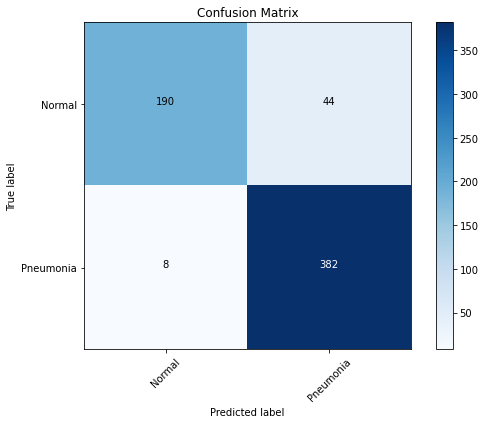

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_pred > 0.5)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=['Normal', 'Pneumonia'], title='Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image

# Load the image
img_path = "C:\\Users\\abi\\Downloads\\archive\\chest_xray\\val\\PNEUMONIA\\person1946_bacteria_4875.jpeg"
img = image.load_img(img_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size

# Preprocess the image
img_array /= 255.  # Normalize pixel values

# Predict the class
prediction = model.predict(img_array)

# Display the prediction result
if prediction[0][0] > 0.5:
    print("Prediction: Pneumonia")
else:
    print("Prediction: Normal")


1/1 [==============================] - 0s 107ms/step
Prediction: Pneumonia
